In [89]:
!cd fused-densenet-tiny && pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 377.1 MB 6.5 kB/s 


In [98]:
pip install 'h5py==2.10.0' --force-reinstall


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 8.3 MB/s 
     |████████████████████████████████| 15.7 MB 19.6 MB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.16.2
    Uninstalling numpy-1.16.2:
      Successfully uninstalled numpy-1.16.2
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 0.20.2 requires pandas>=1.1, but you have pandas 0.25.3 which is incompatible.
kapre 0.3.7 requires tensorflow>=2.0.0, but you have tensorflow 1.14.0 which is incomp

In [2]:
#LOAD DEPENDENCIES
import os
import logging
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import applications
from keras.optimizers import Adam
from keras.models import load_model
from keras.models import Model, Input
from sklearn.utils import class_weight
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Layer, ReLU, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Add, Concatenate, Dropout

#PREVENT ERROR UNCESSARY MESSAGES
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [3]:
#LOAD THE DATA
train_data_dir = "fused-densenet-tiny/dataset/train/"
validation_data_dir = "fused-densenet-tiny/dataset/validation/"

# THE INPUT LAYER IS THE SAME AS IT WILL BE FUSED AS ONE LATER ON
img_rows, img_cols = 224, 224
input_shape = (img_rows,img_cols,3)
model_input = Input(shape=input_shape)
print("Data folders found!")
print("The Input size is set to ", model_input) 

Data folders found!
The Input size is set to  Tensor("input_1:0", shape=(?, 224, 224, 3), dtype=float32)


In [4]:
#DATA GENERATORS

batch_size = 16

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
                                
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows,img_cols),
        batch_size=batch_size,
        class_mode='categorical',
         classes=['0_Normal', '1_Covid19', '2_Pneumonia'])

validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows,img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
         classes=['0_Normal', '1_Covid19', '2_Pneumonia'])

#CHECK  THE NUMBER OF SAMPLES
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)

if nb_train_samples == 0:
    print("NO DATA TRAIN FOUND! Please check your train data path and folders!")
else:
    print("Train samples found!")
    
if nb_validation_samples == 0:
    print("NO DATA VALIDATION FOUND! Please check your validation data path and folders!")
    print("Check the data folders first!")
else:
    print("Validation samples found!")

#check the class indices
train_generator.class_indices
validation_generator.class_indices

#true labels
Y_test=validation_generator.classes

num_classes= len(train_generator.class_indices)

if nb_train_samples and nb_validation_samples > 0:
    print("Generators are set!")
    print("Check if dataset is complete and has no problems before proceeding.")

Found 7367 images belonging to 3 classes.
Found 1841 images belonging to 3 classes.
Train samples found!
Validation samples found!
Generators are set!
Check if dataset is complete and has no problems before proceeding.


In [5]:
#Weight each class

class_weights = class_weight.compute_class_weight(
               class_weight = "balanced",
                classes = np.unique(train_generator.classes), 
                 y = train_generator.classes)

# class_weights = compute_class_weight(
#                                         class_weight = "balanced",
#                                         classes = np.unique(train_classes),
#                                         y = train_classes                                                    
#                                     )
# class_weights = dict(zip(np.unique(train_classes), class_weights))
print(class_weights)

[0.9387105  2.39577236 0.65906244]


In [6]:
# DenseNet121-A 

#TRANSFER LEARNING
def densenet_tiny_A_builder(model_input):
    densenet_tiny_A_builder = DenseNet121(weights='imagenet', include_top=False, input_tensor=model_input)
    
#PARTIAL LAYER FREEZING
    for layer in densenet_tiny_A_builder.layers:
        layer.trainable = False 

#MODEL TRUNCATION
    x = densenet_tiny_A_builder.layers[-354].output
    model = Model(inputs=densenet_tiny_A_builder.input, outputs=x, name='densenet-tiny-A')
    return model

#GENERATE THE MODEL
densenet_tiny_A = densenet_tiny_A_builder(model_input)

#PLOT THE MODEL STRUCTURE
print("PLEASE CHECK THE ENTIRE MODEL UP TO THE END")
densenet_tiny_A.summary()
print("DenseNet-Tiny-A successfully built!")

PLEASE CHECK THE ENTIRE MODEL UP TO THE END
Model: "densenet-tiny-A"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________

In [7]:
# DenseNet121-B

#TRANSFER LEARNING
def densenet_tiny_B_builder(model_input):
    densenet_tiny_B_builder = DenseNet121(weights='imagenet', include_top=False, input_tensor=model_input)
    
#RE-TRAINING ALL LAYERS (RE-NAMING LAYERS TO PREVENT OVERLAPS)
    for layer in densenet_tiny_B_builder.layers:
        layer.trainable = True
        layer.name = layer.name + str("_mirror")

#MODEL TRUNCATION
    x = densenet_tiny_B_builder.layers[-354].output
    model = Model(inputs=densenet_tiny_B_builder.input, outputs=x, name='densenet_tiny-B')
    return model

#GENERATE THE MODEL
densenet_tiny_B = densenet_tiny_B_builder(model_input)

#PLOT THE MODEL STRUCTURE
print("PLEASE CHECK THE ENTIRE MODEL UP TO THE END")
densenet_tiny_B.summary()
print("DenseNet-Tiny-B successfully built!")

PLEASE CHECK THE ENTIRE MODEL UP TO THE END
Model: "densenet_tiny-B"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1_mirror (InputLayer)     (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_3_mirror (ZeroPa (None, 230, 230, 3)  0           input_1_mirror[0][0]             
__________________________________________________________________________________________________
conv1/conv_mirror (Conv2D)      (None, 112, 112, 64) 9408        zero_padding2d_3_mirror[0][0]    
__________________________________________________________________________________________________
conv1/bn_mirror (BatchNormaliza (None, 112, 112, 64) 256         conv1/conv_mirror[0][0]          
________________________________________

In [8]:
#PREPARE THE CONCATENATION OF THE PRE-TRAINED MODELS
densenet_tiny_A = densenet_tiny_A_builder(model_input)
densenet_tiny_B = densenet_tiny_B_builder(model_input)

print("DenseNet-Tiny-A and DenseNet-Tiny-B accomplished Pre-training and ready for concatenation")

DenseNet-Tiny-A and DenseNet-Tiny-B accomplished Pre-training and ready for concatenation


In [9]:
#CONCATENATE AS THE MODELS AS A SINGLE PIPELINE

models = [densenet_tiny_A, 
          densenet_tiny_B]

print("Concatenation success!")
print("Fused-DenseNet-Tiny ready to connect with its ending layers!")

Concatenation success!
Fused-DenseNet-Tiny ready to connect with its ending layers!


In [10]:
#BUILD THE FUSED-DENSENET-TINY

def fused_densenet_tiny(models, model_input):
    outputs = [m.output for m in models]
    y = Add()(outputs)               
    y = GlobalAveragePooling2D()(y)
    y = Dense(512, activation='relu', use_bias=True)(y)
    y = Dropout(0.5)(y)
    prediction = Dense(num_classes,activation='softmax', name='Softmax_Classifier')(y)
    model = Model(model_input, prediction, name='fused_densenet_tiny')
    return model

#istantitate the ensemble model and report the summary
fused_densenet_tiny = fused_densenet_tiny(models,model_input)

print()
print()
print("PLEASE CHECK THE MODEL UP TO THE END")
print("Fused-DenseNet-Tiny complete and ready for compilation and training!")
print()
print()
print()

fused_densenet_tiny.summary()
print("Building of the Fused-DenseNet-Tiny COMPLETE!")



PLEASE CHECK THE MODEL UP TO THE END
Fused-DenseNet-Tiny complete and ready for compilation and training!



Model: "fused_densenet_tiny"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1_mirror_mirror (InputLay (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_5 (ZeroPadding2D (None, 230, 230, 3)  0           input_1_mirror_mirror[0][0]      
__________________________________________________________________________________________________
zero_padding2d_7_mirror (ZeroPa (None, 230, 230, 3)  0           input_1_mirror_mirror[0][0]      
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zer

In [16]:
#MODEL COMPILATION WITH HYPER-PARAMETERS, LOSS FUNCTIONS AND TRAINING!
import time

batch_size = 144

epochs = 5

start_time = time.time()

optimizer = Adam(lr=0.0001)

fused_densenet_tiny.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) 

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.000001)

callbacks = [reduce_lr]

history = fused_densenet_tiny.fit_generator(train_generator, steps_per_epoch=nb_train_samples // batch_size,
                                  epochs=epochs, validation_data=validation_generator,
                                  callbacks=callbacks, 
                                  validation_steps=nb_validation_samples // batch_size, verbose=1)

elapsed_time = time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

#SAVE THE FUSED-DENSENET-TINY AFTER TRAINING COMPLETES

fused_densenet_tiny.save('fused-densenet-tiny/weights/fused_densenet_tiny.h5')


#SAVE THE HISTORY FOR EVALUATION

from pickle import dump
dump(history, open('history/fused_densenet_tiny.pkl', 'wb'))

print("The Fused-DenseNet is successfully trained and save! You may now proceed with the model_evaluation.ipynb")

Epoch 1/5
 1/51 [..............................] - ETA: 20:46 - loss: 0.2162 - acc: 0.9375

KeyboardInterrupt: ignored

In [ ]:
###############################
# START PHASE 2 MODEL EVALUATOR
###############################

In [17]:
#LOAD THE DEPENDENCIES
import os
import PIL
import cv2
import logging
import itertools
import scikitplot 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from pickle import load
from keras import applications
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from keras.models import Model, Input, load_model
from sklearn.metrics import mean_squared_log_error
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121, preprocess_input
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc

#PREVENT ERROR UNCESSARY MESSAGES
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [18]:
#PREPARE THE INPUT LAYER AND DATA FOR VALIDATION

validation_data_dir = "fused-densenet-tiny/dataset/validation/"

img_width, img_height = 224, 224
input_shape = (img_width,img_height,3)
model_input = Input(shape=input_shape)
print("Validation folder found!")
print("The Input size is set to ", model_input) 

Validation folder found!
The Input size is set to  Tensor("input_2:0", shape=(?, 224, 224, 3), dtype=float32)


In [19]:
#HYPER-PARAMETERS USED NO NEED TO CHANGE. MAKE SURE IT MATCHES WITH YOUR TRAINED MODEL. 
#THIS IS MAINLY FOR PLOTTING PURPOSES ONLY

batch_size = 16

epochs = 25

print("Batch Size is set to:", batch_size)
print("Epoch is set to:", epochs)
print()
print("Make sure it matches with your trained model before proceeding to prevent problems")

Batch Size is set to: 16
Epoch is set to: 25

Make sure it matches with your trained model before proceeding to prevent problems


In [20]:
#PREPARE THE VALIDATION DATA GENERATOR
                                
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width,img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
         classes=['0_Normal', '1_Covid19', '2_Pneumonia'])

#identify the number of samples
nb_validation_samples = len(validation_generator.filenames)

#check the class indices
validation_generator.class_indices

#true labels
Y_test=validation_generator.classes
num_classes= len(validation_generator.class_indices)

if validation_generator.class_indices ==3:
    print()
    print("Incorrect number of classes! Please check your folders and data first!")
else:
    print()
    print("Three classes found!")

if nb_validation_samples == 0:
    print("NO DATA VALIDATION FOUND! Please check your validation data path and folders!")
    print("Check the data folders first!")
else:
    print("Validation samples found!")
    
if nb_validation_samples > 0:
    print("Generators are set!")
    print("Check if dataset is complete and has no problems before proceeding.")    

Found 1841 images belonging to 3 classes.

Three classes found!
Validation samples found!
Generators are set!
Check if dataset is complete and has no problems before proceeding.


In [21]:

history = load(open('fused-densenet-tiny/history/fused_densenet_tiny.pkl', 'rb'))
model = load_model('fused-densenet-tiny/weights/fused_densenet_tiny.h5')
model.name="Fused-DenseNet-Tiny"
model.summary()

if len(model.layers) == 152:
    print("MODEL IS READY!")
elif len(model.layers) != 152:
    print("INCORRECT MODEL!")
    
print("FUSED-DENSENET-TINY MODEL SUCCESSFULLY LOADED!")

Model: "Fused-DenseNet-Tiny"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1_2 (InputLayer)          (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_5 (ZeroPadding2D (None, 230, 230, 3)  0           input_1_2[0][0]                  
__________________________________________________________________________________________________
zero_padding2d_7_2 (ZeroPadding (None, 230, 230, 3)  0           input_1_2[0][0]                  
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_5[0][0]           
________________________________________________________________________________

In [22]:
#VISUAL CUSTOMIZER

marker_t = '^'
marker_v = '+'
market_t_loss = 'v'
market_v_loss = 'x'
markersize = 5
fillstyle_t = 'none'
fillstyle_v = 'none'

color_t = 'blue'
color_v = 'orange'

labelsize = 10

color_t_loss = 'green'
color_v_loss = 'red'

border_pad = 0.5
legend_font_size = 9

ls_t = '-' 
ls_v = '--'
lw_t = '1.5'
lw_v = '1.5'

print("You may change the values if needed for the ease of your evaluation")

You may change the values if needed for the ease of your evaluation


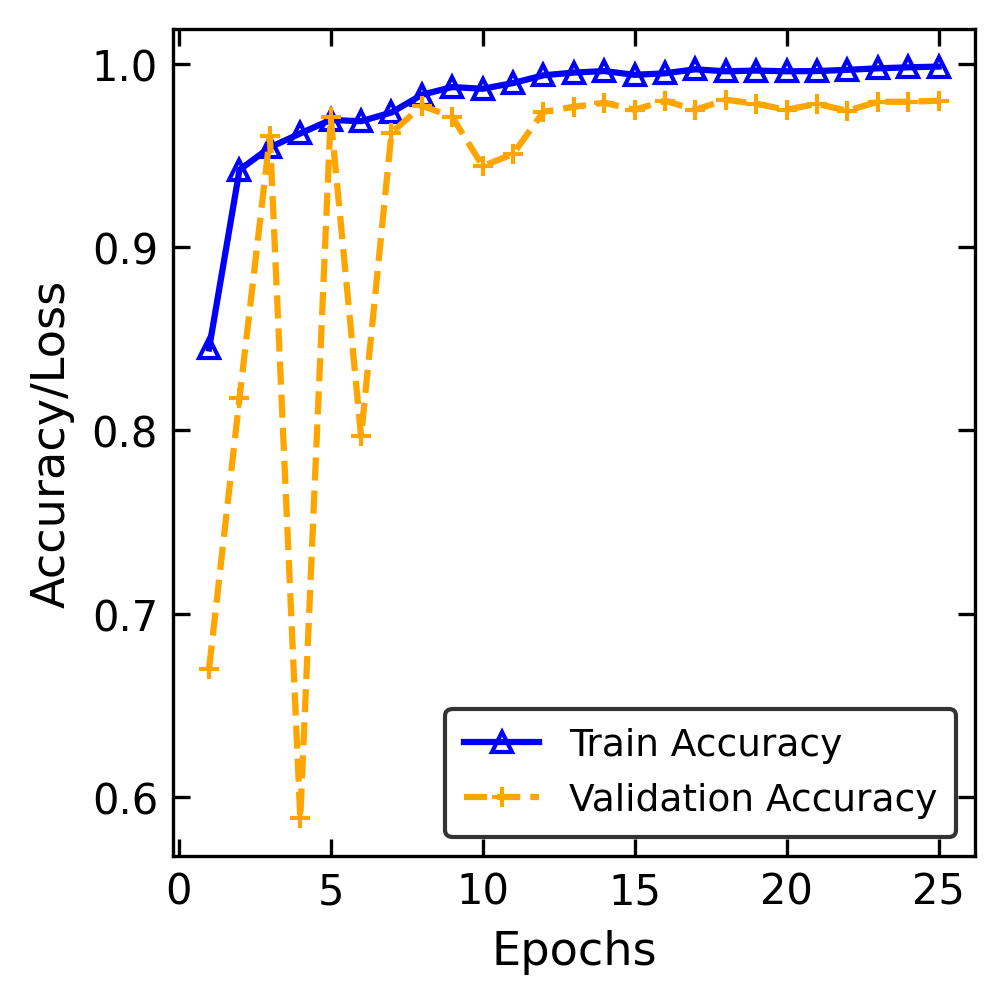

In [26]:
#PRINTS THE ACCURACY GROWTH

N = epochs
plt.style.use("default")
plt.figure(figsize=(1.15*3,1.15*3), dpi=300, edgecolor='black', facecolor='white', linewidth=0)
plt.tight_layout()

plt.gcf().subplots_adjust(bottom=0.15)

plt.rc('xtick',labelsize=labelsize, direction="in" ) 
plt.rc('ytick', labelsize=labelsize, direction="in") 
plt.tick_params(length=4, right=True, top=True)

plt.plot(np.arange(1, N+1), history.history["acc"], color=color_t,lw=lw_t, marker=marker_t, markersize=markersize, fillstyle=fillstyle_t, ls=ls_t, label="Train Accuracy")
plt.plot(np.arange(1, N+1), history.history["val_acc"], color=color_v ,lw=lw_v, marker=marker_v, markersize= markersize, fillstyle=fillstyle_v, ls=ls_v,  label="Validation Accuracy")

plt.xlabel("Epochs", fontsize=3.7*3, color='black')
plt.ylabel("Accuracy/Loss", fontsize=3.7*3, color='black')
plt.legend(loc="lower right", fontsize=legend_font_size, edgecolor='black', borderpad=border_pad)
plt.tight_layout()
plt.savefig("fused-densenet-tiny/figures/1-accuracy.jpg", bbox_inches='tight', dpi=600)

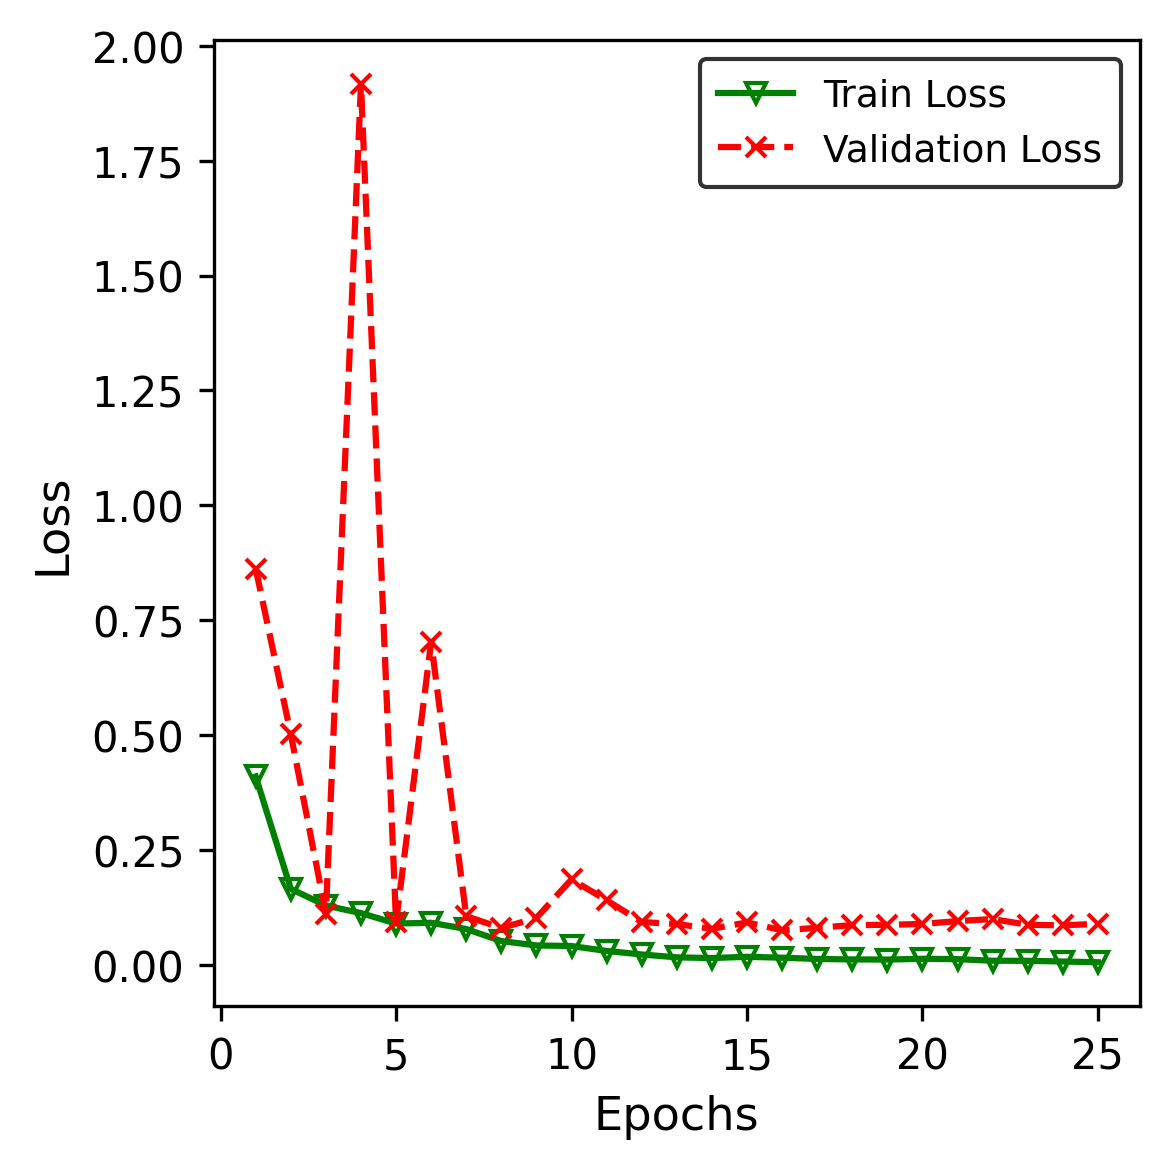

In [28]:
#PRINTS THE DECREASE OF LOSS

N = epochs
plt.style.use("default")
plt.figure(figsize=(4,4), dpi=300)
plt.plot(np.arange(1, N+1), history.history["loss"], color=color_t_loss,lw=lw_t, marker=market_t_loss, markersize=markersize, fillstyle=fillstyle_t, ls=ls_t, label="Train Loss")
plt.plot(np.arange(1, N+1), history.history["val_loss"], color=color_v_loss,lw=lw_v, marker=market_v_loss, markersize= markersize, fillstyle=fillstyle_v, ls=ls_v,  label="Validation Loss")

plt.xlabel("Epochs", fontsize=3.7*3, color='black')
plt.ylabel("Loss", fontsize=3.7*3, color='black')
plt.legend(loc="upper right", fontsize=legend_font_size, edgecolor='black', borderpad=border_pad)
plt.tight_layout()
plt.savefig("fused-densenet-tiny/figures/2-loss.png")

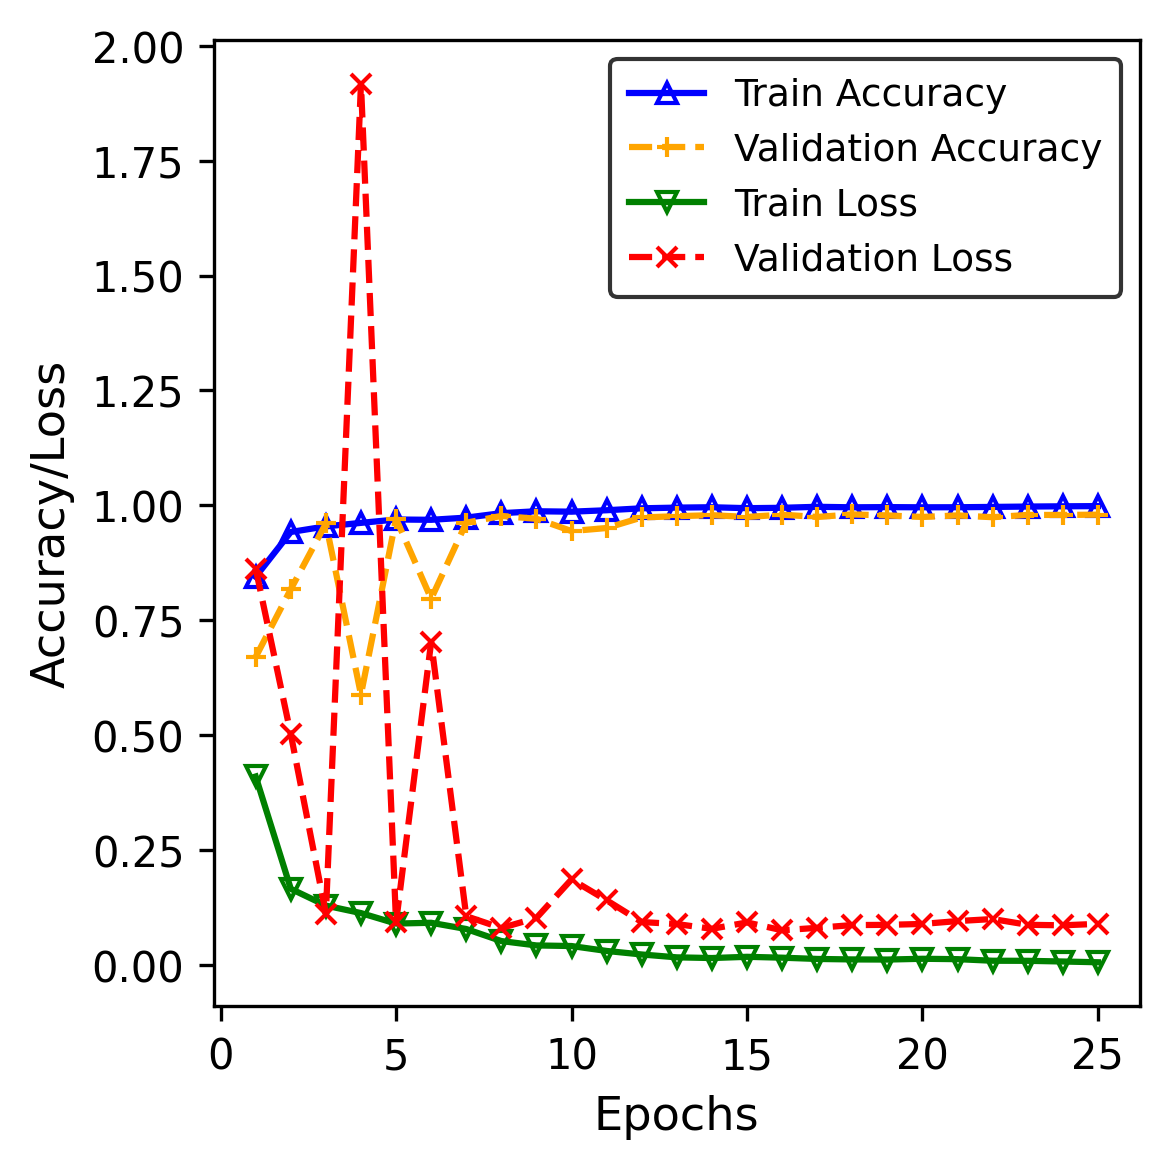

In [29]:
#PRINTS BOTH ACCURACY AND LOSS IN ONE GRAPH

N = epochs
plt.style.use("default")
plt.figure(figsize=(4,4), dpi=300)
plt.plot(np.arange(1, N+1), history.history["acc"], color=color_t,lw=lw_t, marker=marker_t, markersize=markersize, fillstyle=fillstyle_t, ls=ls_t, label="Train Accuracy")
plt.plot(np.arange(1, N+1), history.history["val_acc"], color=color_v ,lw=lw_v, marker=marker_v, markersize= markersize, fillstyle=fillstyle_v, ls=ls_v,  label="Validation Accuracy")
plt.plot(np.arange(1, N+1), history.history["loss"], color=color_t_loss,lw=lw_t, marker=market_t_loss, markersize=markersize, fillstyle=fillstyle_t, ls=ls_t, label="Train Loss")
plt.plot(np.arange(1, N+1), history.history["val_loss"], color=color_v_loss,lw=lw_v, marker=market_v_loss, markersize= markersize, fillstyle=fillstyle_v, ls=ls_v,  label="Validation Loss")

plt.xlabel("Epochs", fontsize=3.7*3, color='black')
plt.ylabel("Accuracy/Loss", fontsize=3.7*3, color='black')
plt.legend(loc="upper right", fontsize=legend_font_size, edgecolor='black', borderpad=border_pad)
plt.tight_layout()
plt.savefig("fused-densenet-tiny/figures/3-convergence.png")

In [30]:
#EVALUATION FOR THE FUSED-DENSENET-TINY

#evaluate accuracy
y_pred = model.predict_generator(validation_generator,
                                               nb_validation_samples/batch_size, workers=1)
accuracy = accuracy_score(Y_test,y_pred.argmax(axis=-1))
print('The accuracy of the Fused DenseNet-Tiny model is: ', accuracy)

#evaluate mean squared error
mse = mean_squared_error(Y_test,y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Fused DenseNet-Tiny model is: ', mse)

#evaluate mean squared log error
msle = mean_squared_log_error(Y_test,y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Fused DenseNet-Tiny model is: ', msle)

The accuracy of the Fused DenseNet-Tiny model is:  0.979902227050516
The Mean Squared Error of the Fused DenseNet-Tiny model is:  0.0755024443237371
The Mean Squared Log Error of the Fused DenseNet-Tiny model is:  0.02290145173783669


              precision    recall  f1-score   support

      Normal     0.9696    0.9755    0.9726       654
    COVID-19     1.0000    0.9883    0.9941       256
   Pneumonia     0.9817    0.9807    0.9812       931

    accuracy                         0.9799      1841
   macro avg     0.9838    0.9815    0.9826      1841
weighted avg     0.9800    0.9799    0.9799      1841

Confusion matrix, without normalization
[[638   0  16]
 [  2 253   1]
 [ 18   0 913]]


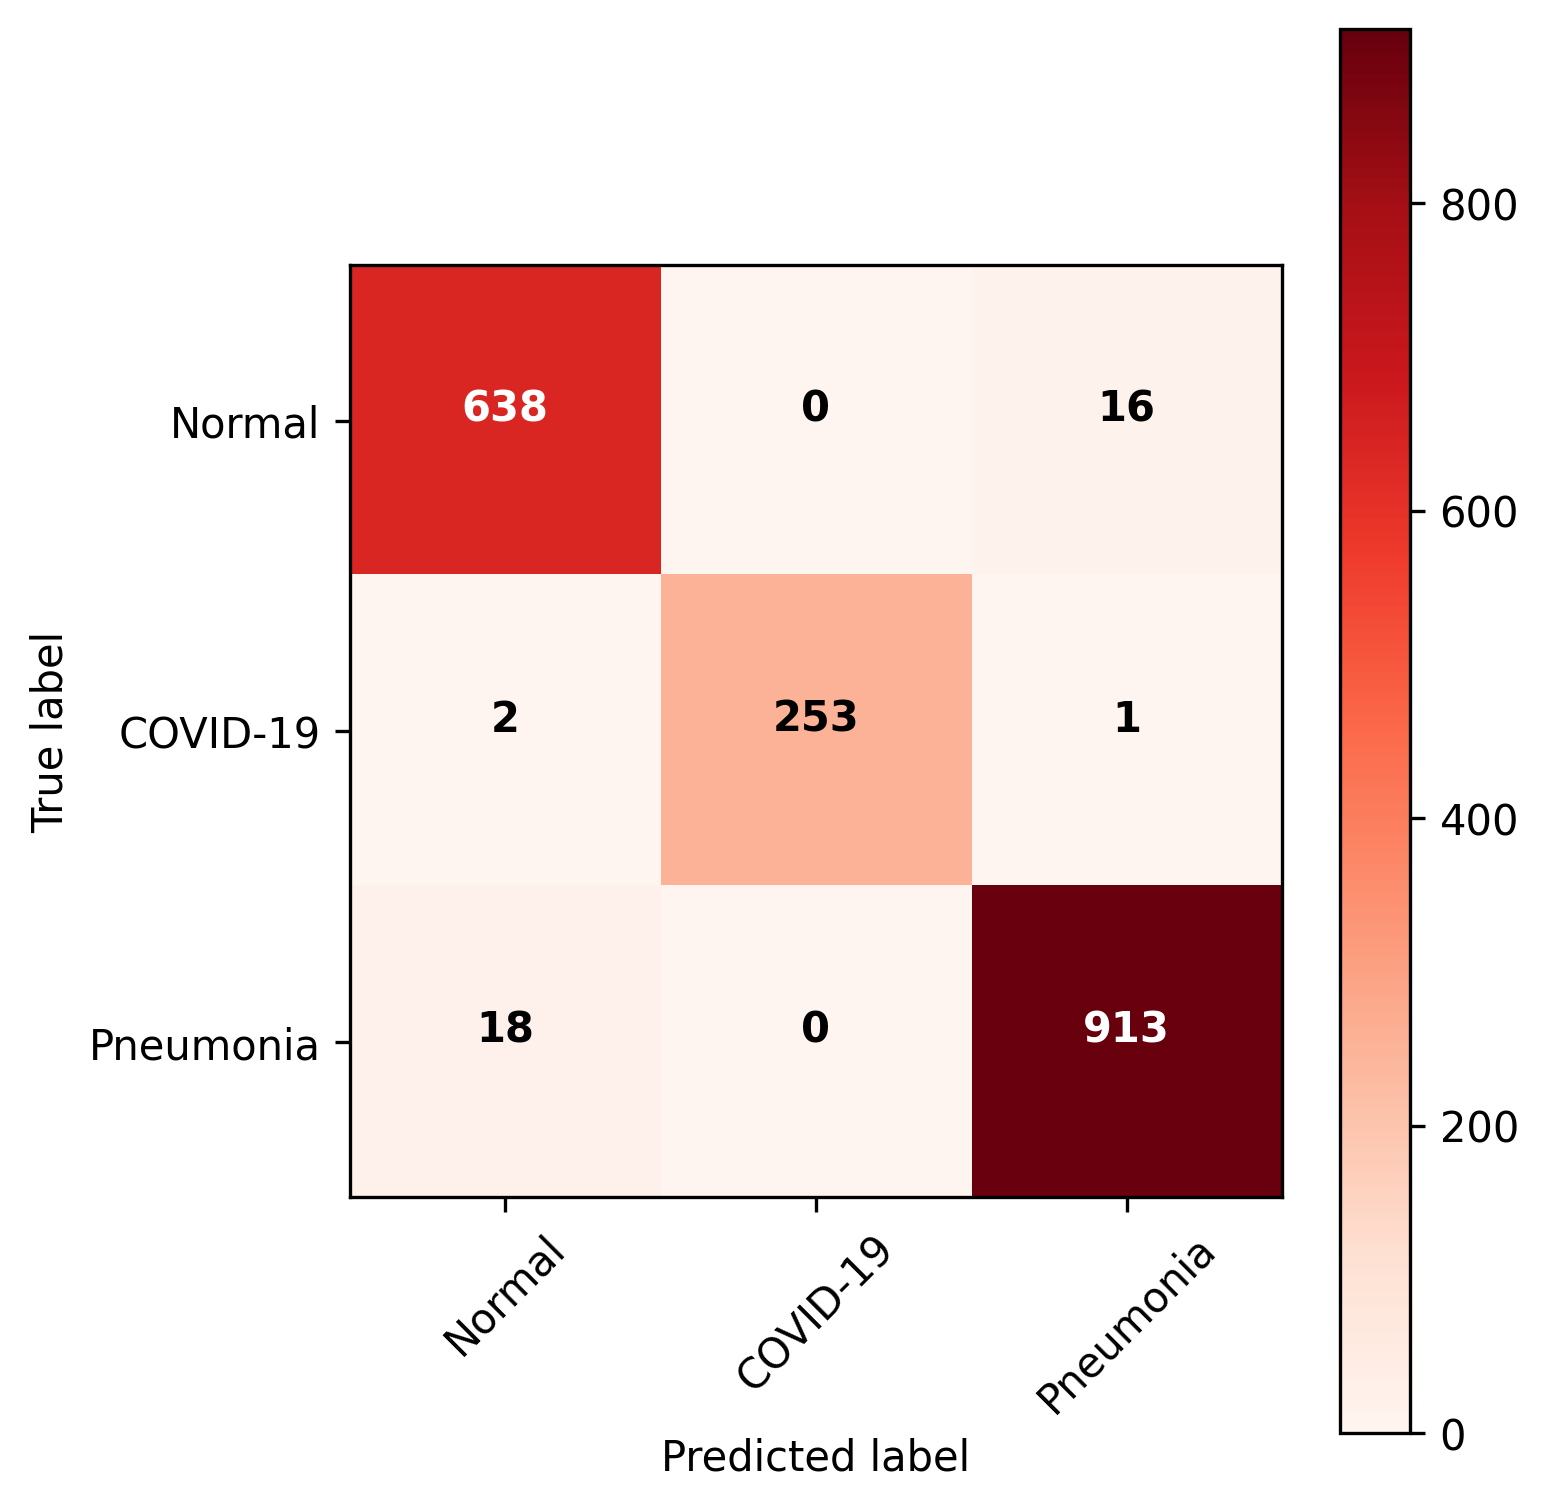

In [31]:
# CONFUSION MATRIX

def plot_confusion_matrix(cm, classes,
                          normalize=False, #if true all values in confusion matrix is between 0 and 1
                          title='',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes, rotation=0)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], weight='bold',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#%% print classification report and plot confusion matrix
plt.style.use("default")
target_names = ['Normal', 'COVID-19', 'Pneumonia']
print(classification_report(Y_test,y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5.25,5.25), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.tight_layout()
plt.savefig("fused-densenet-tiny/figures/confusion_matrix.png", dpi=600)
plt.show()

              precision    recall  f1-score   support

      Normal     0.9696    0.9755    0.9726       654
    COVID-19     1.0000    0.9883    0.9941       256
   Pneumonia     0.9817    0.9807    0.9812       931

    accuracy                         0.9799      1841
   macro avg     0.9838    0.9815    0.9826      1841
weighted avg     0.9800    0.9799    0.9799      1841

Normalized confusion matrix
[[0.9755 0.     0.0245]
 [0.0078 0.9883 0.0039]
 [0.0193 0.     0.9807]]


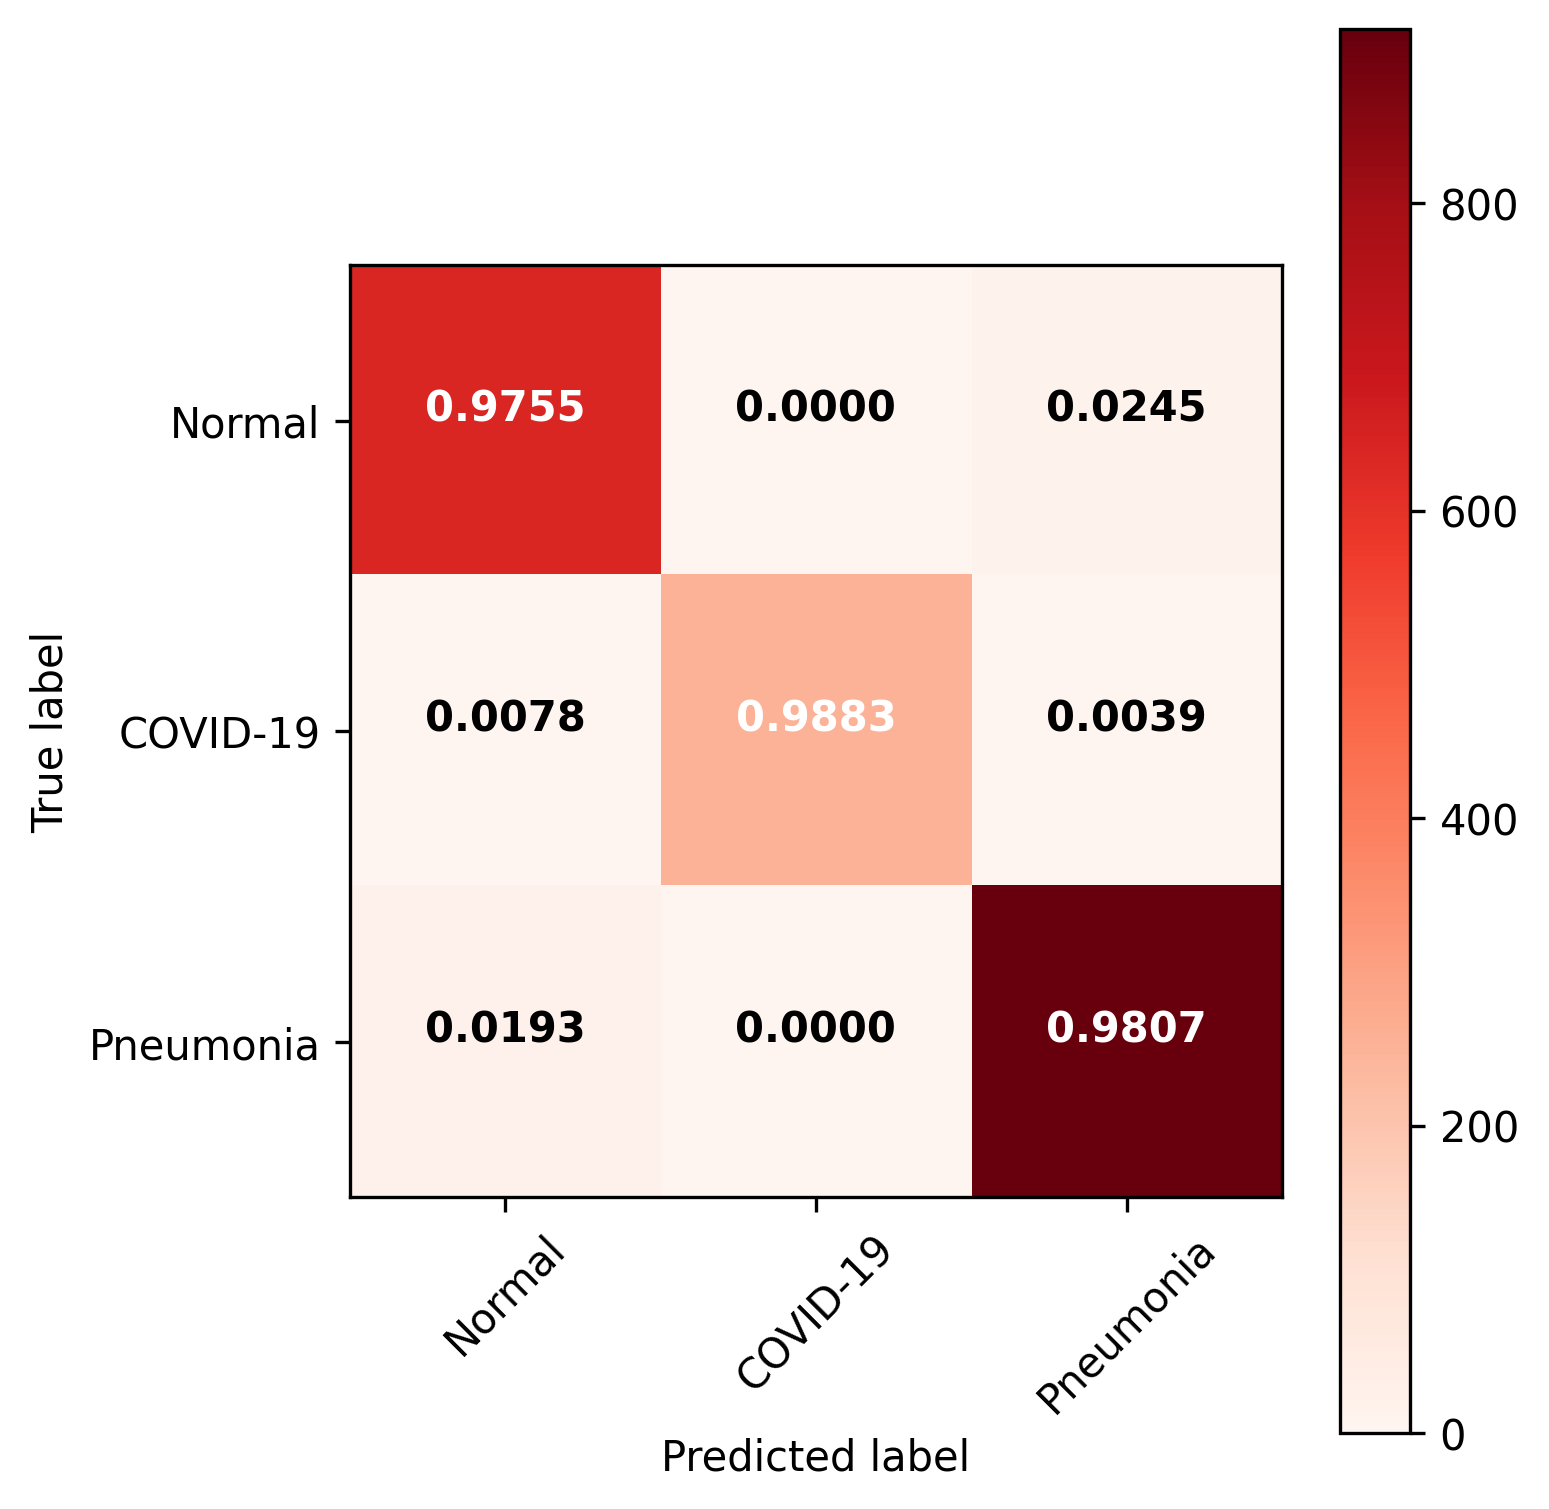

In [32]:
# custom function to plot confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=True, #if true all values in confusion matrix is between 0 and 1
                          title='',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes, rotation=0)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.4f'), weight='bold',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#%% print classification report and plot confusion matrix
plt.style.use("default")
target_names = ['Normal', 'COVID-19', 'Pneumonia']
print(classification_report(Y_test,y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5.25,5.25), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.tight_layout()
plt.savefig("fused-densenet-tiny/figures/confusion_matrix-normalized.png", dpi=600)
plt.show()

<Figure size 2400x2400 with 0 Axes>

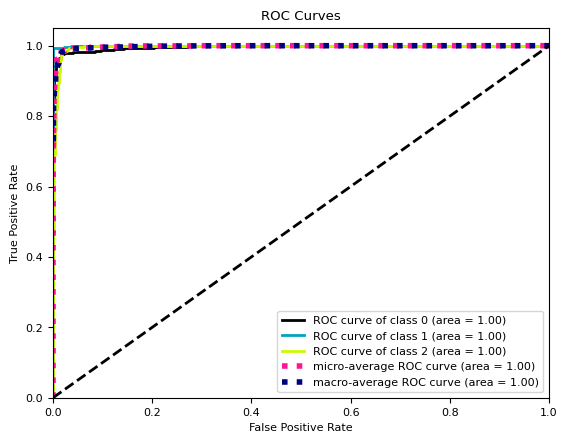

In [33]:
#PRINT THE ROC CURVE

plt.figure(figsize=(8,8), dpi=300)
plt.rcParams.update({'font.size': 8})
y_probas = model.predict(validation_generator)
scikitplot.metrics.plot_roc(Y_test, y_pred)
plt.savefig("fused-densenet-tiny/figures/ROC_curve.png", dpi=600)
plt.show()

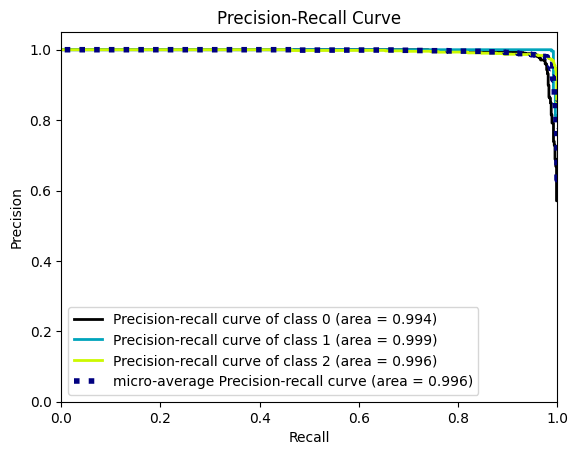

<Figure size 6000x6000 with 0 Axes>

In [34]:
#PRINT THE P-R CURVE

plt.rcParams.update({'font.size': 10})
y_probas = model.predict(validation_generator)
scikitplot.metrics.plot_precision_recall(Y_test, y_pred)
plt.savefig("fused-densenet-tiny/figures/PR_curve.png", dpi=600)
plt.figure(figsize=(20, 20), dpi=300) 
plt.show()

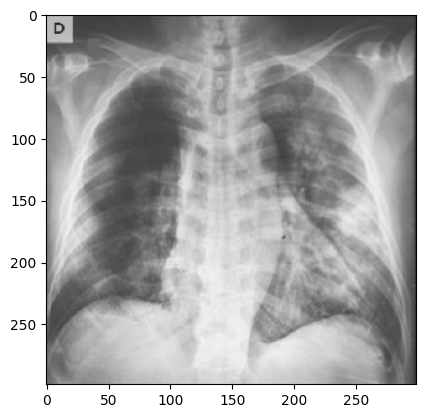

In [38]:

img_path = 'fused-densenet-tiny/test/1.jpg'

img1 = image.load_img(img_path)
plt.imshow(img1);

img = image.load_img(img_path, target_size=(img_width, img_height))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [39]:
preds = model.predict(x)
preds

array([[1.4674e-06, 9.9996e-01, 3.8749e-05]], dtype=float32)

In [40]:
result = np.argmax(preds[0])
result

1

In [41]:
#TAKE THE FEATURE IMPORTANCES FROM THE LAST CONV LAYER

grad_output = model.output[:, result]
last_conv_layer = model.get_layer('add_1')

grads = K.gradients(grad_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

#RANGE OF 224 IS BASED ON THE MAXIMUM FILTERS

for i in range(224):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if __name__ == '__main__':


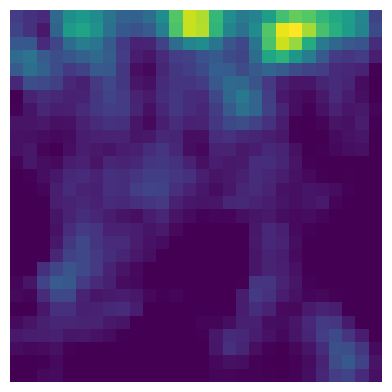

In [42]:
#PRODUCE THE GRAD-CAM HEATMAP

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.grid = False
plt.axis('off')
plt.savefig('fused-densenet-tiny/grad-cam/sample.jpg', dpi=300, papertype='a4', bbox_inches=None,  pad_inches=0.0, facecolor=None)
plt.tight_layout()

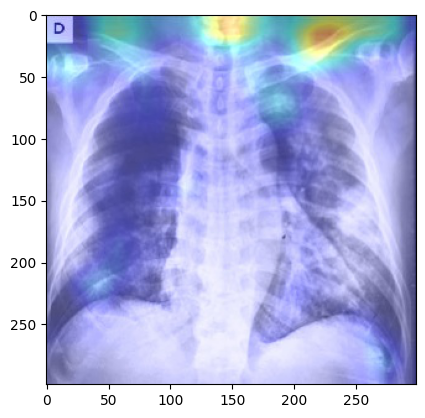

In [43]:
#PRINT THE OVERLAY

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(200 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

save_img_path = 'fused-densenet-tiny/grad-cam/ample.jpg'

cv2.imwrite(save_img_path, superimposed_img)

img1 = image.load_img(save_img_path)
plt.imshow(img1);

In [ ]:
#################################
#the thirs phase#################
#################################

In [44]:
#LOAD THE DEPENDENCIES
import os
import logging
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input

#PREVENTS UNWANTED PROMPTS
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [45]:
#LOAD THE TRAINED MODEL

model = load_model("fused-densenet-tiny/weights/fused_densenet_tiny.h5") 
print("FUSED-DENSENET-TINY INITIALIZED!")
print("The model consist of ", len(model.layers), "layers")

FUSED-DENSENET-TINY INITIALIZED!
The model consist of  152 layers


In [46]:
#CHOOSE ANY IMAGE FROM YOUR DATASET
img_path = '/content/fused-densenet-tiny/dataset/train/1_Covid19/COVID-19 (1020).jpg' #YOU CAN CHANGE THIS

Image successfully loaded for diagnosis


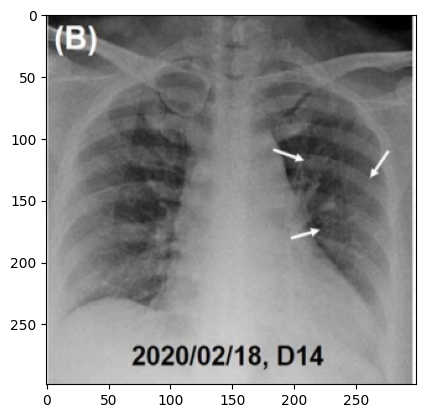

In [47]:
#PREPARE THE DATA INPUT

img_width, img_height = 224, 224

img1 = image.load_img(img_path)
plt.imshow(img1);

img = image.load_img(img_path, target_size=(img_width, img_height))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print("Image successfully loaded for diagnosis")

In [48]:
#PREPARE THE FUSED-DENSENET-TINY FOR TESTING

def fused_densenet_tiny(x, model):
    
    conf = model.predict(x)
    conf_score = max(100 * conf[0])
    
    predictions = model.predict(x).argmax()   
    plt.imshow(img)
    
    if predictions == 2:
        print("The X-Ray was diagnosed to potentially have have Pneumonia.")
        print("The confidence of the model is roughly", conf_score,"%.")
        print()
        print("Further test and observation is required.")
       
    elif predictions == 1:
        print("he X-Ray was diagnosed to potentially have COVID-19.")
        print("The confidence of the model is roughly", conf_score,"%.")
        print()
        print("Further test and observation is required.")
        
    else:
        print("The X-Ray seems to be Normal without signs of COVID-19 or Pneumonia infections.")
        print("The confidence of the model is roughly", conf_score,"%.")
        print()
        print("The patient may still consult for further test to be sure.")

he X-Ray was diagnosed to potentially have COVID-19.
The confidence of the model is roughly 100.0 %.

Further test and observation is required.


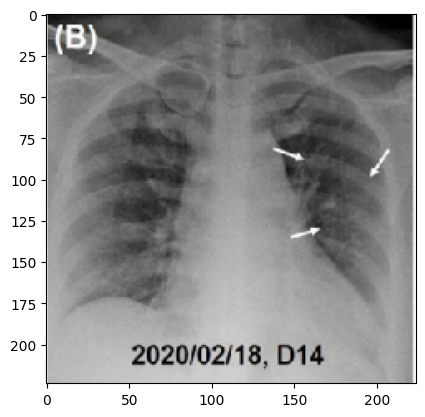

In [49]:
#DIAGNOSE THE INPUT IMAGE WITH THE FUSED-DENSENET-TINY

fused_densenet_tiny(x, model)